# Variuos Stuff

## Load Data

In [1]:
from datasets import load_dataset

dataset = load_dataset("multi_woz_v22")
dataset

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Reusing dataset multi_woz_v22 (/home/ilya/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/7452f16a8b502e97df5c04cc4ee5436464762fa93b1ce778dd14181e79d8b51a)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 8437
    })
    validation: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 1000
    })
})

In [2]:
topics = dataset['validation']['services']
uniques = set()
for tops in topics:
    for top in tops:
        uniques.add(top)
uniques

{'attraction', 'hospital', 'hotel', 'restaurant', 'taxi', 'train'}

## Extract Utterances

In [3]:
import pandas as pd
import json

# data for all further experiments
n_dialogues = 15
data = dataset['validation']['turns'][:n_dialogues]

# separate utterances
utterances = []
speaker = []
for dia in data:
    utterances.extend(dia['utterance'])
    speaker.extend(dia['speaker'])
df = pd.DataFrame({'text': utterances})
df.to_csv('aug-data/original.csv')
json.dump(speaker, open('aug-data/speaker.json', 'w'))


# lengths of dialogues
# to restore dialogues from utterances
rle = [len(dia['utterance']) for dia in data]
json.dump(rle, open('aug-data/rle.json', 'w'))

## DGAC

Понадобится для вычисления функций близости

In [ ]:
! mkdir data
! python3 parse_multiwoz.py
! python3 sentence_encoding.py
! python3 dgac_clustering.py

## Visualize Clusters

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
from dgac_clustering import Clusters
import json
import numpy as np


clusterer: Clusters = pickle.load(open('clust-data/dgac_clusterer.pickle', 'rb'))
X = np.load('clust-data/sentence_embeddings.npy')
speaker = np.array(json.load(open('clust-data/speakers.json', 'r')))


def show_clusters(is_user=True):
    mask = (speaker == 1 - is_user)
    # project
    projected = TSNE().fit_transform(X[mask], clusterer.labels_user)
    
    # define colors
    n_clusters = len(np.unique(clusterer.labels_user))
    hex_syms = [a for a in '0123456789abcdef']
    base_colors = ['#' + ''.join(a for a in np.random.choice(hex_syms, size=6)) for _ in range(n_clusters)]
    colors = [base_colors[i] for i in clusterer.labels_user]

    # visualize
    plt.scatter(projected[:, 0], projected[:, 1], color=colors, s=5)
    plt.axis('off')
    plt.title(f'{n_clusters=}')

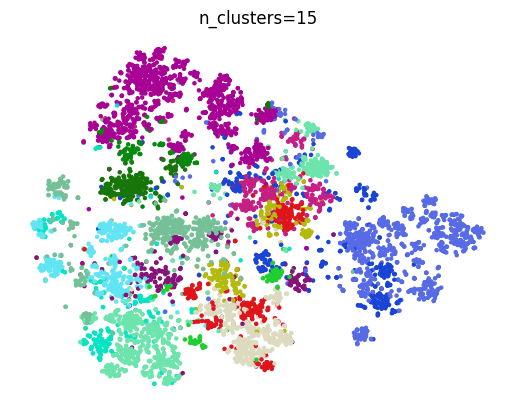

In [24]:
show_clusters()

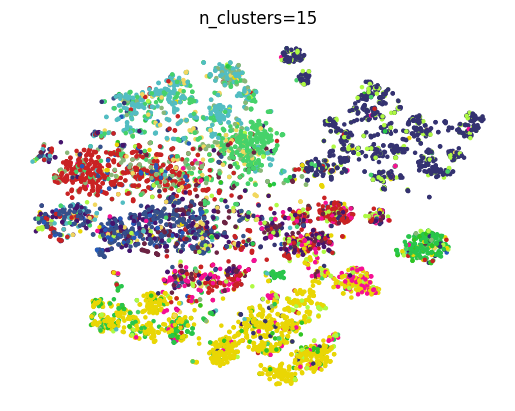

In [25]:
show_clusters(False)

## `textattack` package

[textattack augment](https://github.com/QData/TextAttack#augmenting-text-textattack-augment
)

In [31]:
speaker

'AB'

In [34]:
from redlines import Redlines
from IPython.display import Markdown, display
import json
import numpy as np


def read_csv(path):
    res = []
    with open(path, 'r') as f:
        f.readline() # row with column names
        for line in f.readlines():
            utter = ','.join(line.split(',')[1:])
            res.append(utter.replace('"', ''))
    return res


original = read_csv('aug-data/original.csv')
speaker = np.array(json.load(open('clust-data/speaker.json', 'r')))
rle = json.load(open('aug-data/rle.json', 'r'))

speaker_alias = "AB"
def show_augmented(i, name):
    augmented = read_csv(f'aug-data/{name}.csv')
    start = sum(rle[:i])
    end = start + rle[i]
    orig = '\n'.join([f'[{speaker_alias[j]}] {ut}' for j, ut in zip(speaker[start:end], original[start:end])])
    aug = '\n'.join([f'[{speaker_alias[j]}] {ut}' for j, ut in zip(speaker[start:end], augmented[start:end])])

    display(Markdown(Redlines(orig, aug).output_markdown))

### Embedding

Заменяем слово на другое слово, эмбеддинг которого ближе всех к эмбеддингу заменяемого слова 

In [20]:
! textattack augment\
    --input-csv aug-data/original.csv\
    --output-csv aug-data/embedding.csv\
    --input-column text\
    --recipe embedding\
    --pct-words-to-swap .1\
    --transformations-per-example 1\
    --exclude-original

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


710.59s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


2023-07-29 01:20:43.487826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-29 01:20:45.315161: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
textattack: Read 240 rows from aug-data/original.csv. Found columns {'', 'text'}.
Augmenting rows: 100%|████████████████████████| 240/240 [00:11<00:00, 20.32it/s]
textattack: Wrote 240 augmentations to aug-data/embedding.csv in 14.817251920700073s.


In [35]:
show_augmented(14, 'embedding')

[A] I <span style='color:red;font-weight:700;text-decoration:line-through;'>need </span><span style='color:green;font-weight:700;'>require </span>a train from birmingham new street to cambridge, please. 

[B] There are 133 trains <span style='color:red;font-weight:700;text-decoration:line-through;'>traveling </span><span style='color:green;font-weight:700;'>trip </span>that path. What day would you like to travel on? 

[A] I would like to leave on <span style='color:red;font-weight:700;text-decoration:line-through;'>Wednesday </span><span style='color:green;font-weight:700;'>Monday </span>sometime after 11:30. 

[B] How about the TR1670? It meets your specifications and <span style='color:red;font-weight:700;text-decoration:line-through;'>leaves </span><span style='color:green;font-weight:700;'>sheets </span>at 11:40. 

[A] How <span style='color:red;font-weight:700;text-decoration:line-through;'>long </span><span style='color:green;font-weight:700;'>longue </span>is the train ride? 

[B] The train ride is 163 <span style='color:red;font-weight:700;text-decoration:line-through;'>minutes, </span><span style='color:green;font-weight:700;'>mins, </span>does this suit your needs? 

[A] <span style='color:red;font-weight:700;text-decoration:line-through;'>How </span><span style='color:green;font-weight:700;'>Mode </span>much is the fare on that train? 

[B] It is 75.10 <span style='color:red;font-weight:700;text-decoration:line-through;'>pounds. ¶ [A] What </span><span style='color:green;font-weight:700;'>pound. </span>

<span style='color:green;font-weight:700;'>[A] Quoi </span>is the exact arrival time? I'm also looking for a place to dine in the centre of town. I'm looking for an expensive modern european <span style='color:red;font-weight:700;text-decoration:line-through;'>restaurant. </span><span style='color:green;font-weight:700;'>lunchroom. </span>

[B] Let's take <span style='color:red;font-weight:700;text-decoration:line-through;'>care </span><span style='color:green;font-weight:700;'>healthcare </span>of the train first. The train will arrive by 14:23 in Cambridge. Would you like to book a <span style='color:red;font-weight:700;text-decoration:line-through;'>ticket? </span><span style='color:green;font-weight:700;'>tickets? </span>

[A] Thank you I do not <span style='color:red;font-weight:700;text-decoration:line-through;'>need to book </span><span style='color:green;font-weight:700;'>gotta to cookbook </span>the train, but I am looking for an expensive restaurant in the centre of town. 

[B] We have many expensive places in the center of town! Is there a <span style='color:red;font-weight:700;text-decoration:line-through;'>particular </span><span style='color:green;font-weight:700;'>singular </span>type of cuisine you'd <span style='color:red;font-weight:700;text-decoration:line-through;'>like </span><span style='color:green;font-weight:700;'>fond </span>to try? 

[A] I would like modern European <span style='color:red;font-weight:700;text-decoration:line-through;'>food. </span><span style='color:green;font-weight:700;'>diet. </span>

[B] How about darrys cookhouse and <span style='color:red;font-weight:700;text-decoration:line-through;'>wine </span><span style='color:green;font-weight:700;'>vineyard </span>shop? 

[A] Yeah that should work can I please get the <span style='color:red;font-weight:700;text-decoration:line-through;'>address </span><span style='color:green;font-weight:700;'>addressing </span>post code and phone number? 

[B] They are <span style='color:red;font-weight:700;text-decoration:line-through;'>located </span><span style='color:green;font-weight:700;'>positioned </span>at 40270 King Street City Centre. Postcode is cb11ln. Phone number is 01223505015. Can I book a <span style='color:red;font-weight:700;text-decoration:line-through;'>table </span><span style='color:green;font-weight:700;'>chalkboard </span>for you? 

[A] No thank you. I will go <span style='color:red;font-weight:700;text-decoration:line-through;'>ahead </span><span style='color:green;font-weight:700;'>upcoming </span>and book myself. Thank you so much. This was all the info I <span style='color:red;font-weight:700;text-decoration:line-through;'>needed. </span><span style='color:green;font-weight:700;'>required. </span>Have a good day. 

[B] <span style='color:red;font-weight:700;text-decoration:line-through;'>We </span><span style='color:green;font-weight:700;'>Ours </span>appreciate your business. Thank for using the Cambridge Towninfo centre! Have a great day!

Безконтекстная замена создает грамматические ошибки

### Checklist

Заменить названия, числа, удлиннить или укоротить фразы.

In [46]:
! textattack augment\
    --input-csv utterances.csv\
    --output-csv aug-checklist.csv\
    --input-column text\
    --recipe checklist\
    --pct-words-to-swap .1\
    --transformations-per-example 1\
    --exclude-original

textattack: Read 240 rows from utterances.csv. Found columns {'', 'text'}.
Augmenting rows: 100%|████████████████████████| 240/240 [00:14<00:00, 16.61it/s]
textattack: Wrote 240 augmentations to aug-checklist.csv in 14.455964088439941s.


In [36]:
show_augmented(14, 'checklist')

[A] I need a train from <span style='color:red;font-weight:700;text-decoration:line-through;'>birmingham </span><span style='color:green;font-weight:700;'>St. Cloud </span>new street to cambridge, please. 

[B] There are <span style='color:red;font-weight:700;text-decoration:line-through;'>133 </span><span style='color:green;font-weight:700;'>93 </span>trains traveling that path. What day would you like to travel on? 

[A] I would like to leave on Wednesday sometime after <span style='color:red;font-weight:700;text-decoration:line-through;'>11:30. </span><span style='color:green;font-weight:700;'>11:4. </span>

[B] How about the TR1670? It meets your specifications and leaves at <span style='color:red;font-weight:700;text-decoration:line-through;'>11:40. </span><span style='color:green;font-weight:700;'>13:40. </span>

[A] How long is the train ride? 

[B] The train ride is <span style='color:red;font-weight:700;text-decoration:line-through;'>163 </span><span style='color:green;font-weight:700;'>249 </span>minutes, does this suit your needs? 

[A] How much is the fare on that train? 

[B] It is <span style='color:red;font-weight:700;text-decoration:line-through;'>75.10 </span><span style='color:green;font-weight:700;'>75.16 </span>pounds. 

[A] What is the exact arrival time? I'm also looking for a place to dine in the centre of town. <span style='color:red;font-weight:700;text-decoration:line-through;'>I'm </span><span style='color:green;font-weight:700;'>I am </span>looking for an expensive modern european restaurant. 

[B] <span style='color:red;font-weight:700;text-decoration:line-through;'>Let's </span><span style='color:green;font-weight:700;'>Shon </span>take care of the train first. The train will arrive by <span style='color:red;font-weight:700;text-decoration:line-through;'>14:23 </span><span style='color:green;font-weight:700;'>14:37 </span>in Cambridge. Would you like to book a ticket? 

[A] Thank you I <span style='color:red;font-weight:700;text-decoration:line-through;'>do not </span><span style='color:green;font-weight:700;'>don't </span>need to book the train, but <span style='color:red;font-weight:700;text-decoration:line-through;'>I am </span><span style='color:green;font-weight:700;'>I'm </span>looking for an expensive restaurant in the centre of town. 

[B] We have many expensive places in the center of town! Is there a particular type of cuisine <span style='color:red;font-weight:700;text-decoration:line-through;'>you'd </span><span style='color:green;font-weight:700;'>you would </span>like to try? 

[A] <span style='color:red;font-weight:700;text-decoration:line-through;'>I would </span><span style='color:green;font-weight:700;'>I'd </span>like modern European food. 

[B] How about darrys cookhouse and wine shop? 

[A] Yeah that should work can I please get the address post code and phone number? 

[B] They are located at <span style='color:red;font-weight:700;text-decoration:line-through;'>40270 </span><span style='color:green;font-weight:700;'>35271 </span>King Street City Centre. Postcode is cb11ln. Phone number is <span style='color:red;font-weight:700;text-decoration:line-through;'>01223505015. </span><span style='color:green;font-weight:700;'>46547340. </span>Can I book a table for you? 

[A] No thank you. <span style='color:red;font-weight:700;text-decoration:line-through;'>I will </span><span style='color:green;font-weight:700;'>I'll </span>go ahead and book myself. Thank you so much. This was all the info I needed. Have a good day. 

[B] We appreciate your business. Thank for using the Cambridge Towninfo centre! Have a great day!

### CLARE

Заменяем токены, вставляем, соединяем и заменяем --- с помощью MLM.

In [54]:
! textattack augment\
    --input-csv utterances.csv\
    --output-csv aug-clare.csv\
    --input-column text\
    --recipe clare\
    --pct-words-to-swap .1\
    --transformations-per-example 1\
    --exclude-original

2023-07-28 16:24:01.653839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 16:24:02.255426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-28 16:24:04.327086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-28 16:24:04.327460: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

In [37]:
show_augmented(14, 'clare')

[A] I need a <span style='color:green;font-weight:700;'>carriage </span>train from birmingham new street to cambridge, please. 

[B] There are <span style='color:green;font-weight:700;'>about </span>133 trains traveling that path. What day would you like to travel on? 

[A] I <span style='color:green;font-weight:700;'>absolutely </span>would like to leave on Wednesday sometime after 11:30. 

[B] How about the TR1670? It meets your specifications and leaves at <span style='color:green;font-weight:700;'>the </span>11:40. 

[A] How long is <span style='color:green;font-weight:700;'>not </span>the train ride? 

[B] The train ride is <span style='color:green;font-weight:700;'>barely </span>163 minutes, does this suit your needs? 

[A] How much is the fare <span style='color:green;font-weight:700;'>calculated </span>on that train? 

[B] It is 75.10 <span style='color:green;font-weight:700;'>lb </span>pounds. 

[A] What is <span style='color:green;font-weight:700;'>often </span>the exact arrival time? I'm also looking for a place to dine in the centre of town. I'm looking for an expensive modern european restaurant. 

[B] Let's take care of the train <span style='color:red;font-weight:700;text-decoration:line-through;'>first. </span><span style='color:green;font-weight:700;'>logistics. </span>The train will arrive by 14:23 in Cambridge. Would you like to book a <span style='color:green;font-weight:700;'>tour </span>ticket? 

[A] Thank you <span style='color:green;font-weight:700;'>guys </span>I do not need to book the train, but I am looking for an expensive restaurant in the centre of town. 

[B] We have many expensive places in the center of town! Is there a particular type <span style='color:green;font-weight:700;'>fare </span>of cuisine you'd like to try? 

[A] I would like modern <span style='color:red;font-weight:700;text-decoration:line-through;'>European </span><span style='color:green;font-weight:700;'>Asian </span>food. 

[B] How about darrys cookhouse and wine <span style='color:green;font-weight:700;'>glasses </span>shop? 

[A] Yeah that should work can I please <span style='color:green;font-weight:700;'>try </span>get the address post code and phone number? 

[B] They are located at 40270 King <span style='color:red;font-weight:700;text-decoration:line-through;'>Street City </span><span style='color:green;font-weight:700;'>don </span>Centre. <span style='color:red;font-weight:700;text-decoration:line-through;'>Postcode </span><span style='color:green;font-weight:700;'>Name </span>is cb11ln. Phone number is 01223505015. Can I book a table for you? 

[A] No thank you. I will go ahead and book myself. <span style='color:green;font-weight:700;'>Seriously </span>Thank you so much. This was all the info I needed. Have a good day. 

[B] We appreciate your <span style='color:red;font-weight:700;text-decoration:line-through;'>business. </span><span style='color:green;font-weight:700;'>inconvenience. </span>Thank for using the Cambridge Towninfo centre! Have a great day!

## Count Vectorizer over Cluster Labels

In [39]:
from sentence_encoding import sentence_encoder
import pickle
from dgac_clustering import Clusters
import json
import numpy as np


speaker = np.array(json.load(open('aug-data/speaker.json', 'r')))
clusterer: Clusters = pickle.load(open('clust-data/dgac_clusterer.pickle', 'rb'))
rle = json.load(open('aug-data/rle.json', 'r'))

names = ['original', 'checklist', 'clare', 'embedding']

for name in names:
    utterances = read_csv(f'aug-data/{name}.csv')
    embeddings = sentence_encoder(utterances)
    
    labels_user, labels_system = clusterer.predict(embeddings, speaker)
    labels = np.empty(len(embeddings), dtype=np.int16)
    labels[speaker == 0] = labels_user
    labels[speaker == 1] = labels_system + clusterer.n_clusters

    vectors = []
    for i in range(len(rle)):
        start = sum(rle[:i])
        end = start + rle[i]
        dialogue = labels[start:end]

        vec = np.zeros(clusterer.n_clusters * 2)
        for label in dialogue:
            vec[label] += 1
        vectors.append(vec)
    
    np.save(f'aug-data/vectors-{name}', vectors)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [40]:
def intersection(vec_i, vec_j):
    return np.minimum(vec_i, vec_j).sum()

def dice(vec_i, vec_j):
    return 2 * np.minimum(vec_i, vec_j).sum() / (vec_i.sum() + vec_j.sum())

def compute_similarities(func, name):
    orig_vecs = np.load(f'aug-data/vectors-original.npy')
    aug_vecs = np.load(f'aug-data/vectors-{name}.npy')
    
    return [func(orig, aug) for orig, aug in zip(orig_vecs, aug_vecs)]

In [41]:
compute_similarities(dice, 'original')

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [42]:
compute_similarities(dice, 'clare')

[0.9166666666666666,
 0.8,
 0.8333333333333334,
 0.8333333333333334,
 0.9,
 0.8333333333333334,
 0.9375,
 0.75,
 0.9642857142857143,
 0.9375,
 0.9615384615384616,
 0.75,
 0.8888888888888888,
 1.0,
 1.0]

In [44]:
compute_similarities(dice, 'checklist')

[1.0,
 0.95,
 1.0,
 0.9166666666666666,
 1.0,
 1.0,
 1.0,
 0.875,
 0.9285714285714286,
 1.0,
 0.9615384615384616,
 1.0,
 1.0,
 1.0,
 1.0]

In [45]:
compute_similarities(dice, 'embedding')

[0.9166666666666666,
 0.85,
 0.8333333333333334,
 0.9166666666666666,
 0.9,
 0.8333333333333334,
 0.875,
 0.75,
 0.8928571428571429,
 0.9375,
 0.9230769230769231,
 0.875,
 0.8333333333333334,
 1.0,
 0.8888888888888888]

## ChatGPT API

In [72]:
from dotenv import load_dotenv

load_dotenv()

True

In [73]:
import os
import openai


openai.api_key = os.environ['OPENAI_KEY']

In [74]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

In [75]:
prompt = """
Below, in triple backticks, is a dialogue between a client and a service worker on the topic of {topic}. The symbols [A] and [B] indicate the belonging of the remarks to the client and the employee (which of them specifically is unknown).

Your task is to rewrite the original dialogue in an informal style. You can change the vocabulary. You can not change the order of the lines, change the meaning of the dialogue and phrases in general.

Respond only with dialogue, without any additional comments.

```{dialogue}```
"""

In [77]:
responses = []
for i, (topic, dialogue) in enumerate(zip(topics, dialogues)):
    if i > 10:
        break
    response = get_completion(prompt.format(topic=', '.join(topic), dialogue=dialogue))
    responses.append(response)

RateLimitError: You exceeded your current quota, please check your plan and billing details.

In [78]:
responses

[]

## ChatGPT Web UI

In [69]:
from redlines import Redlines
from IPython.display import Markdown, display


def test(orig, new):
    test = Redlines(orig, new)
    display(Markdown(test.output_markdown))

### Stop Utterances

Промт такой:
```
Below, in triple quotes, is a dialogue between a client and a service worker on the topic of hotel, taxi and entertainment. The symbols [A] and [B] indicate the belonging of the replicas to the client and the employee (which of them specifically is unknown).

Your task is to add to some replicas such phrases that do not add or distort the meaning of the dialogue as a whole, do not change the sequence of replies of the speakers. Added phrases should be no longer than 5-10 words. You can add to any part of the dialogue and to any part of phrases.

You are not allowed to delete words and phrases or change the words of the original dialogue in any way. The final dialogue must comply with the rules of grammar.

Are you ready to get dialogue in triple quotes? Say yes or no
```

In [49]:
orig = """
[A] My husband and I are celebrating our anniversary and want to find a great place to stay in town.
[B] Congratulations on your upcoming anniversary! Cambridge offers a variety of lodging options, what is your price range?
[A] I would like a 4 star guesthouse that includes free parking.
[B] I have several options for you, is there a particular area you are interested in during your stay?
[A] yes should be in the west
[B] I have one guesthouse that fits that criteria, Finches Bed and Breakfast. Would you like me to book for you?
[A] Yes, please! We'll arrive on Monday and stay 2 nights. Just the two of us, of course!
[B] Ok, your hotel stay at Finches Bed and Breakfast is booked, Reference number FKRO2HOW . Will there be anything else?
[A] I am wanting to know more about the Cambridge Museum of Technology.
[B] Sure, it's located in the centre area of town. The phone number is 01223368650. The entrance fee is 5 pounds.
[A] What is the address, please.
[B] The address is the old pumping station, cheddars lane. Did you want any more information about the museum?
[A] Yes, I need the entrance fee. I will also need a taxi to pick me up by 24:30. I need the contact number and car type please.
[B] The entrance fee is 5 pounds.
[A] Can you book the taxi for me at 24:30 leaving from the museum please. I will need the contact number and the car type.
[B] and what is your destination ?
[A] I will leave the Cambridge Museum at 24:30, going to the the Finches Bed and Breakfast.
[B] Your taxi has been booked. It will be a grey volvo and the contact number is 07239297218.
[A] Thanks so much. That is all I need for today. Bye.
[B] Have a nice stay!
"""

In [50]:
new = """
<A> My husband and I are celebrating our anniversary and want to find a great place to stay in town.
<B> Congratulations on your upcoming anniversary! Cambridge offers a variety of lodging options, what is your price range?
<A> I would like a 4-star guesthouse that includes free parking, please.
<B> I have several options for you. Is there a particular area you are interested in during your stay?
<A> Yes, it should be in the west, please.
<B> I have one guesthouse that fits that criteria, Finches Bed and Breakfast. Would you like me to book it for you?
<A> Yes, please! We'll arrive on Monday and stay 2 nights. Just the two of us, of course!
<B> Ok, your hotel stay at Finches Bed and Breakfast is booked, Reference number FKRO2HOW. Will there be anything else?
<A> I am wanting to know more about the Cambridge Museum of Technology, actually.
<B> Sure, it's located in the center area of town. The phone number is 01223368650. The entrance fee is 5 pounds.
<A> What is the address, please.
<B> The address is the old pumping station, Cheddars Lane. Did you want any more information about the museum?
<A> Yes, I need the entrance fee. Also, I will need a taxi to pick me up by 24:30. Can you provide the contact number and car type, please?
<B> The entrance fee is 5 pounds.
<A> Can you book the taxi for me at 24:30, leaving from the museum, please? I will need the contact number and the car type.
<B> Sure, and what is your destination?
<A> I will leave the Cambridge Museum at 24:30, going to Finches Bed and Breakfast.
<B> Your taxi has been booked. It will be a grey Volvo, and the contact number is 07239297218.
<A> Thanks so much. That is all I need for today. Bye.
<B> Have a nice stay!
"""

In [55]:
def repl(txt):
    txt = txt.replace('<', '[')
    return txt.replace('>', ']')

In [56]:
new = repl(new)

In [61]:
test(orig, new)

[A] My husband and I are celebrating our anniversary and want to find a great place to stay in town. 

[B] Congratulations on your upcoming anniversary! Cambridge offers a variety of lodging options, what is your price range? 

[A] I would like a <span style='color:red;font-weight:700;text-decoration:line-through;'>4 star </span><span style='color:green;font-weight:700;'>4-star </span>guesthouse that includes free <span style='color:red;font-weight:700;text-decoration:line-through;'>parking. </span><span style='color:green;font-weight:700;'>parking, please. </span>

[B] I have several options for <span style='color:red;font-weight:700;text-decoration:line-through;'>you, is </span><span style='color:green;font-weight:700;'>you. Is </span>there a particular area you are interested in during your stay? 

[A] <span style='color:red;font-weight:700;text-decoration:line-through;'>yes </span><span style='color:green;font-weight:700;'>Yes, it </span>should be in the <span style='color:red;font-weight:700;text-decoration:line-through;'>west </span><span style='color:green;font-weight:700;'>west, please. </span>

[B] I have one guesthouse that fits that criteria, Finches Bed and Breakfast. Would you like me to book <span style='color:green;font-weight:700;'>it </span>for you? 

[A] Yes, please! We'll arrive on Monday and stay 2 nights. Just the two of us, of course! 

[B] Ok, your hotel stay at Finches Bed and Breakfast is booked, Reference number <span style='color:red;font-weight:700;text-decoration:line-through;'>FKRO2HOW . </span><span style='color:green;font-weight:700;'>FKRO2HOW. </span>Will there be anything else? 

[A] I am wanting to know more about the Cambridge Museum of <span style='color:red;font-weight:700;text-decoration:line-through;'>Technology. </span><span style='color:green;font-weight:700;'>Technology, actually. </span>

[B] Sure, it's located in the <span style='color:red;font-weight:700;text-decoration:line-through;'>centre </span><span style='color:green;font-weight:700;'>center </span>area of town. The phone number is 01223368650. The entrance fee is 5 pounds. 

[A] What is the address, please. 

[B] The address is the old pumping station, <span style='color:red;font-weight:700;text-decoration:line-through;'>cheddars lane. </span><span style='color:green;font-weight:700;'>Cheddars Lane. </span>Did you want any more information about the museum? 

[A] Yes, I need the entrance fee. <span style='color:green;font-weight:700;'>Also, </span>I will <span style='color:red;font-weight:700;text-decoration:line-through;'>also </span>need a taxi to pick me up by 24:30. <span style='color:red;font-weight:700;text-decoration:line-through;'>I need </span><span style='color:green;font-weight:700;'>Can you provide </span>the contact number and car <span style='color:red;font-weight:700;text-decoration:line-through;'>type please. </span><span style='color:green;font-weight:700;'>type, please? </span>

[B] The entrance fee is 5 pounds. 

[A] Can you book the taxi for me at <span style='color:red;font-weight:700;text-decoration:line-through;'>24:30 </span><span style='color:green;font-weight:700;'>24:30, </span>leaving from the <span style='color:red;font-weight:700;text-decoration:line-through;'>museum please. </span><span style='color:green;font-weight:700;'>museum, please? </span>I will need the contact number and the car type. 

[B] <span style='color:green;font-weight:700;'>Sure, </span>and what is your <span style='color:red;font-weight:700;text-decoration:line-through;'>destination ? </span><span style='color:green;font-weight:700;'>destination? </span>

[A] I will leave the Cambridge Museum at 24:30, going to <span style='color:red;font-weight:700;text-decoration:line-through;'>the the </span>Finches Bed and Breakfast. 

[B] Your taxi has been booked. It will be a grey <span style='color:red;font-weight:700;text-decoration:line-through;'>volvo </span><span style='color:green;font-weight:700;'>Volvo, </span>and the contact number is 07239297218. 

[A] Thanks so much. That is all I need for today. Bye. 

[B] Have a nice stay!

In [63]:
new2 = """
<A> My husband and I are celebrating our anniversary and want to find a great place to stay in town.
<B> Congratulations on your upcoming anniversary! Cambridge offers a variety of lodging options, what is your price range?
<A> I would like a 4-star guesthouse that includes free parking, please.
<B> I have several options for you. Is there a particular area in the west you are interested in during your stay?
<A> Yes, it should be in the west.
<B> I have one guesthouse that fits that criteria, Finches Bed and Breakfast. Would you like me to book it for you?
<A> Yes, please! We'll arrive on Monday and stay 2 nights, just the two of us, of course!
<B> Ok, your hotel stay at Finches Bed and Breakfast is booked. Here is the reference number FKRO2HOW. Will there be anything else?
<A> I am wanting to know more about the Cambridge Museum of Technology.
<B> Sure, it's located in the center area of town. The phone number is 01223368650. The entrance fee is 5 pounds.
<A> What is the address, please?
<B> The address is the old pumping station, Cheddars Lane. Did you want any more information about the museum?
<A> Yes, I need to know the entrance fee. I will also need a taxi to pick me up by 24:30. Could you provide the contact number and car type, please?
<B> The entrance fee is 5 pounds.
<A> Can you please book the taxi for me at 24:30, leaving from the museum? I will need the contact number and the car type.
<B> Sure, your taxi has been booked. It will be a grey Volvo, and the contact number is 07239297218.
<A> Thanks so much. That is all I need for today. Bye.
<B> Have a nice stay!
"""

In [64]:
test(orig, new2)

[A] My husband and I are celebrating our anniversary and want to find a great place to stay in town. 

[B] Congratulations on your upcoming anniversary! Cambridge offers a variety of lodging options, what is your price range? 

[A] I would like a <span style='color:red;font-weight:700;text-decoration:line-through;'>4 star </span><span style='color:green;font-weight:700;'>4-star </span>guesthouse that includes free <span style='color:red;font-weight:700;text-decoration:line-through;'>parking. </span><span style='color:green;font-weight:700;'>parking, please. </span>

[B] I have several options for <span style='color:red;font-weight:700;text-decoration:line-through;'>you, is </span><span style='color:green;font-weight:700;'>you. Is </span>there a particular area <span style='color:green;font-weight:700;'>in the west </span>you are interested in during your stay? 

[A] <span style='color:red;font-weight:700;text-decoration:line-through;'>yes </span><span style='color:green;font-weight:700;'>Yes, it </span>should be in the <span style='color:red;font-weight:700;text-decoration:line-through;'>west </span><span style='color:green;font-weight:700;'>west. </span>

[B] I have one guesthouse that fits that criteria, Finches Bed and Breakfast. Would you like me to book <span style='color:green;font-weight:700;'>it </span>for you? 

[A] Yes, please! We'll arrive on Monday and stay 2 <span style='color:red;font-weight:700;text-decoration:line-through;'>nights. Just </span><span style='color:green;font-weight:700;'>nights, just </span>the two of us, of course! 

[B] Ok, your hotel stay at Finches Bed and Breakfast is <span style='color:red;font-weight:700;text-decoration:line-through;'>booked, Reference number FKRO2HOW . </span><span style='color:green;font-weight:700;'>booked. Here is the reference number FKRO2HOW. </span>Will there be anything else? 

[A] I am wanting to know more about the Cambridge Museum of Technology. 

[B] Sure, it's located in the <span style='color:red;font-weight:700;text-decoration:line-through;'>centre </span><span style='color:green;font-weight:700;'>center </span>area of town. The phone number is 01223368650. The entrance fee is 5 pounds. 

[A] What is the address, <span style='color:red;font-weight:700;text-decoration:line-through;'>please. </span><span style='color:green;font-weight:700;'>please? </span>

[B] The address is the old pumping station, <span style='color:red;font-weight:700;text-decoration:line-through;'>cheddars lane. </span><span style='color:green;font-weight:700;'>Cheddars Lane. </span>Did you want any more information about the museum? 

[A] Yes, I need <span style='color:green;font-weight:700;'>to know </span>the entrance fee. I will also need a taxi to pick me up by 24:30. <span style='color:red;font-weight:700;text-decoration:line-through;'>I need </span><span style='color:green;font-weight:700;'>Could you provide </span>the contact number and car <span style='color:red;font-weight:700;text-decoration:line-through;'>type please. </span><span style='color:green;font-weight:700;'>type, please? </span>

[B] The entrance fee is 5 pounds. 

[A] Can you <span style='color:green;font-weight:700;'>please </span>book the taxi for me at <span style='color:red;font-weight:700;text-decoration:line-through;'>24:30 </span><span style='color:green;font-weight:700;'>24:30, </span>leaving from the <span style='color:red;font-weight:700;text-decoration:line-through;'>museum please. </span><span style='color:green;font-weight:700;'>museum? </span>I will need the contact number and the car type. 

[B] <span style='color:red;font-weight:700;text-decoration:line-through;'>and what is your destination ? ¶ [A] I will leave the Cambridge Museum at 24:30, going to the the Finches Bed and Breakfast. ¶ [B] Your </span><span style='color:green;font-weight:700;'>Sure, your </span>taxi has been booked. It will be a grey <span style='color:red;font-weight:700;text-decoration:line-through;'>volvo </span><span style='color:green;font-weight:700;'>Volvo, </span>and the contact number is 07239297218. 

[A] Thanks so much. That is all I need for today. Bye. 

[B] Have a nice stay!

### Informal Style

Промт:
```
Below, in triple quotes, is a dialogue between a client and a service worker on the topic of a hotel, taxi and entertainment. The symbols [A] and [B] indicate the belonging of the remarks to the client and the employee (which of them specifically is unknown).

Your task is to rewrite the original dialogue in an informal style. You can change the vocabulary. You can not change the order of the lines, change the meaning of the dialogue and phrases in general.

Are you ready to get the dialogue in triple quotes? Say yes or no
```

In [ ]:
new = """
[A] Hey, my hubby and I are gonna celebrate our anniversary and we're on the hunt for an awesome place to crash in town.
[B] Oh, congrats on your upcoming anniversary! Cambridge has lots of places to stay. What's your budget like?
[A] I'm thinking a 4-star guesthouse with free parking.
[B] Gotcha! Any specific area you wanna be in during your stay?
[A] Yeah, somewhere in the west would be perfect.
[B] Cool, I've got one option that fits the bill: Finches Bed and Breakfast. Wanna book it?
[A] Absolutely! We'll be rolling in on Monday and staying for 2 nights. Just us two, ya know!
[B] Awesome! I've booked your stay at Finches Bed and Breakfast. Your reference number is FKRO2HOW. Need anything else?
[A] Yeah, I wanna know more about the Cambridge Museum of Technology.
[B] No problemo! It's in the center of town. You can reach them at 01223368650, and the entrance fee is 5 quid.
[A] Sweet, thanks! And where exactly is it located?
[B] The address is the old pumping station, Cheddars Lane. Need more info about the museum?
[A] Yeah, I need the entrance fee again. Oh, and I'll also need a cab to pick us up at 24:30. Can you give me the contact number and car type, please?
[B] Entrance fee is 5 quid, just to remind ya. And sure thing, I've booked the taxi for ya. It'll be a grey Volvo, and the contact number is 07239297218.
[A] Thanks a bunch! That's all I needed for today. Bye!
[B] Have a blast during your stay! Enjoy!
"""